## 集成预测器
集成模型是用集成学习的思想去把多个PaddleTS的预测器集合成一个预测器。目前我们支持两种集成预测器StackingEnsembleForecaster 和 WeightingEnsembleForecaster

步骤包括：

1.准备数据

2.准备模型

3.组装和拟合模型

4.进行回测

5.模型保存与加载

### 1.准备数据

<AxesSubplot:xlabel='date'>

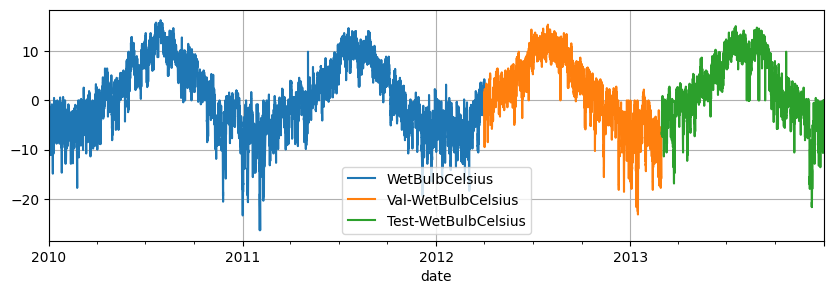

In [7]:
#获取PaddleTS内置数据集
from paddlets.datasets.repository import get_dataset
tsdataset = get_dataset("WTH")

#分割数据成训练集/测试集/验证集
ts_train, ts_val_test = tsdataset.split("2012-03-31 23:00:00")
ts_val, ts_test = ts_val_test.split("2013-02-28 23:00:00")
ts_train.plot(add_data=[ts_val, ts_test], labels=['Val', 'Test'])

In [8]:
#用StandardScaler去归一化数据（可选）
from paddlets.transform.sklearn_transforms import StandardScaler
scaler = StandardScaler()
scaler.fit(ts_train)
ts_train = scaler.transform(ts_train)
ts_val = scaler.transform(ts_val)
ts_test = scaler.transform(ts_test)
ts_val_test = scaler.transform(ts_val_test)

### 2. 准备模型
准备集成预测器需要的底层模型

请注意，为了保持模型预测的一致性， <font color=red>in_chunk_len</font>,  <font color=red>out_chunk_len</font>,  <font color=red>skip_chunk_len</font>, 这三个参数已经被提取到集成模型中，您可以在base模型的参数中忽略这三个参数。

In [9]:
from paddlets.models.forecasting import MLPRegressor
from paddlets.models.forecasting import NHiTSModel
from paddlets.models.forecasting import RNNBlockRegressor



nhits_params = {
    'sampling_stride': 24,
    'eval_metrics':["mse", "mae"],
    'batch_size': 32,
    'max_epochs': 10,
    'patience': 100
}
rnn_params = {
    'sampling_stride': 24,
    'eval_metrics': ["mse", "mae"],
    'batch_size': 32,
    'max_epochs': 10,
    'patience': 100,
}
mlp_params = {
    'sampling_stride': 24,
    'eval_metrics': ["mse", "mae"],
    'batch_size': 32,
    'max_epochs': 10,
    'patience': 100,
    'use_bn': True,
}

### 3. 组装和拟合模型

In [11]:
from paddlets.ensemble import StackingEnsembleForecaster

reg = StackingEnsembleForecaster(
in_chunk_len=7 * 24,
out_chunk_len=24,
skip_chunk_len=0,
estimators=[(NHiTSModel, nhits_params),(RNNBlockRegressor, rnn_params), (MLPRegressor, mlp_params)])

reg.fit(ts_train, ts_val)

/Users/qiguoning01/Desktop/Erised/baidu/new_bts1/baidu/erised/bts/bts/models/representation/dl/cost.py:217: DeprecationWarning: invalid escape sequence \[
  """
/Users/qiguoning01/Desktop/Erised/baidu/new_bts1/baidu/erised/bts/bts/models/representation/dl/ts2vec.py:122: DeprecationWarning: invalid escape sequence \[
  """
[2022-11-02 19:41:06,391] [bts.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 2.044766| val_0_mse: 0.627053| val_0_mae: 0.615734| 0:00:02s
[2022-11-02 19:41:08,549] [bts.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.995072| val_0_mse: 0.477169| val_0_mae: 0.541606| 0:00:04s
[2022-11-02 19:41:10,678] [bts.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.724469| val_0_mse: 0.393254| val_0_mae: 0.483179| 0:00:06s
[2022-11-02 19:41:12,862] [bts.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.579931| val_0_mse: 0.354661| val_0_mae: 0.458536| 0:00:08s
[2022-11-02 19:41:15,002] [bts.models.common.callbacks.callbacks] [INFO]

[2022-11-02 19:41:45,249] [bts.models.common.callbacks.callbacks] [INFO] Best weights from best epoch are automatically used!
[2022-11-02 19:41:45,263] [bts.utils.utils] [WARNING] error occurred while import autots, err: No module named 'ray'


### 4. 进行回测

[2022-11-02 19:44:08,506] [bts.utils.backtest] [INFO] Parameter 'predict_window' not set, default set to model.out_chunk_len 24
[2022-11-02 19:44:08,509] [bts.utils.backtest] [INFO] Parameter 'stride' not set, default set to predict_window 24
[2022-11-02 19:44:08,519] [bts.utils.utils] [WARNING] error occurred while import autots, err: No module named 'ray'
Backtest Progress: 100%|████████████████████████████████████████████████████| 306/306 [00:12<00:00, 25.50it/s]


<AxesSubplot:xlabel='date'>

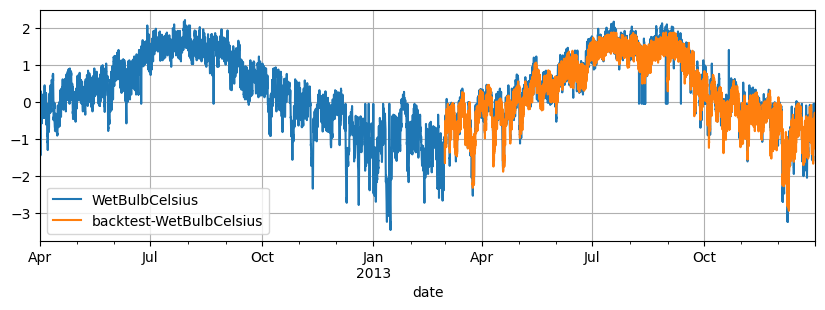

In [16]:
from paddlets.utils import backtest
from paddlets.metrics import MAE
mae, ts_pred = backtest(data=ts_val_test,
                model=reg,
                start="2013-03-01 00:00:00", 
                metric=MAE(),
                return_predicts=True
                )

ts_val_test.plot(add_data=ts_pred,labels="backtest")

### 5.模型保存与加载

In [17]:
#保存模型
reg.save(path="/tmp/ensemble_test1/")


#加载模型
from paddlets.ensemble import StackingEnsembleForecaster
reg = StackingEnsembleForecaster.load(path="/tmp/ensemble_test1/")